<a href="https://colab.research.google.com/github/LulzCo/GTSRB/blob/main/gtsrb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

목차
- 개요
- 필요성
- 관련 연구/내용
  - CNN
  - Tensorflow-Keras
- 내용요약
- 코드 설명
  - 환경세팅
  - 사용 라이브러리
  - 시각화
  - 신경망 모델 구축
  - 모델 학습
  - 테스트
  - 테스트 결과

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- kaggle 데이터를 받아오기 위한 라이브러리 설치

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ysw991106","key":"ff6349adc7a4e549390b246f618c5a46"}'}

- kaggle api를 사용하기 위해서 api key를 업로드해야함 -> kaggle 홈페이지에서 api key를 생성하여 구글 드라이브에 업로드하기

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

- 업로드한 kaggle api key를 .kaggle 디렉터리에 copy

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

- api key에 접근할 수 있도록 권한 부여

In [6]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Nov 21 15:49 kaggle.json


- 권한 확인

In [7]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 612M/612M [00:04<00:00, 237MB/s]
100% 612M/612M [00:04<00:00, 155MB/s]


- 데이터셋 다운로드

In [8]:
!unzip gtsrb-german-traffic-sign.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  inflating: train/

- 압축 파일 풀기

In [36]:
import pandas as pd
import numpy as np
import os
import pathlib
import cv2
from PIL import Image
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')

np.random.seed(42)

%matplotlib inline


- 라이브러리 세팅
  - pandas: 데이터 분석할 때 주로 사용하는 라이브러리
  - numpy: 숫자 관련 라이브러리
  - os: 운영체제 정보를 가지고 올 수 있는 라이브러리
  - pathlib: 경로 데이터를 가지고 올 수 있는 라이브러리
  - cv2: 이미지나 영상과 같은 시각 데이터에 사용하는 오픈소스 라이브러리
  - PIL: 파이썬 이미지 처리 라이브러리
  - ternsorflow: 시각 데이터를 활용한 인공지능에 활용되는 오픈소스 라이브러리
  - sklearn: 기계 학습에 사용되는 라이브러리

- 자세한 함수는 코드 설명 부분에서 추가 설명

- line 23 -> 난수 랜덤성 고정: 딥러닝 모델에 사용하는 모든 랜덤성을 가질만한 라이브러리들에 대한 시드들을 고정해줘야 한다.

In [10]:
data_dir = pathlib.Path('/content/Meta')
train_path = pathlib.Path('/content/Train')
test_path = pathlib.Path('/content/Test')

- 파일 경로 세팅

In [26]:
IMG_HEIGHT = 30
IMG_WIDTH = 30
IMG_CHANNAL = 3

- 이미지에 대한 고정값 세팅 -> 높이, 폭, 채널(rgb)

In [12]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

- 데이터 분류 갯수 확인

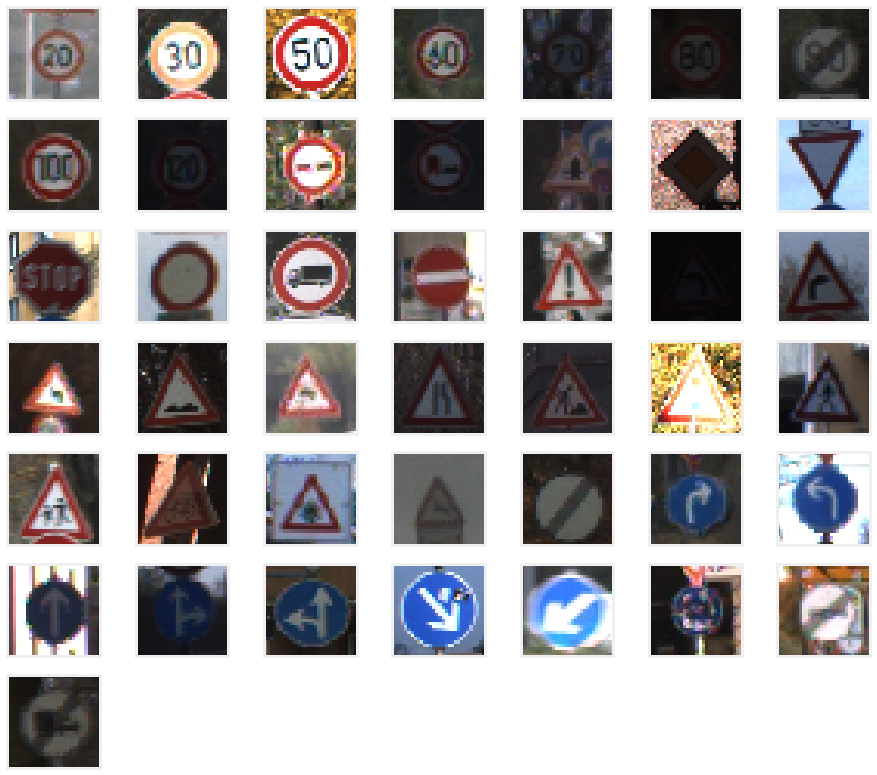

In [19]:
img_dir = pathlib.Path('/content/train')
plt.figure(figsize=(14,14))
index = 0

for i in range(NUM_CATEGORIES):
  plt.subplot(7, 7, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  sign = list(img_dir.glob(f'{i}/*'))[0]
  img = load_img(sign, target_size=(IMG_WIDTH, IMG_HEIGHT))
  plt.imshow(img)
plt.show()

- 교통표지판 시각화

In [14]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

- 캐들 데이터 코드를 참고한 라벨링 작업

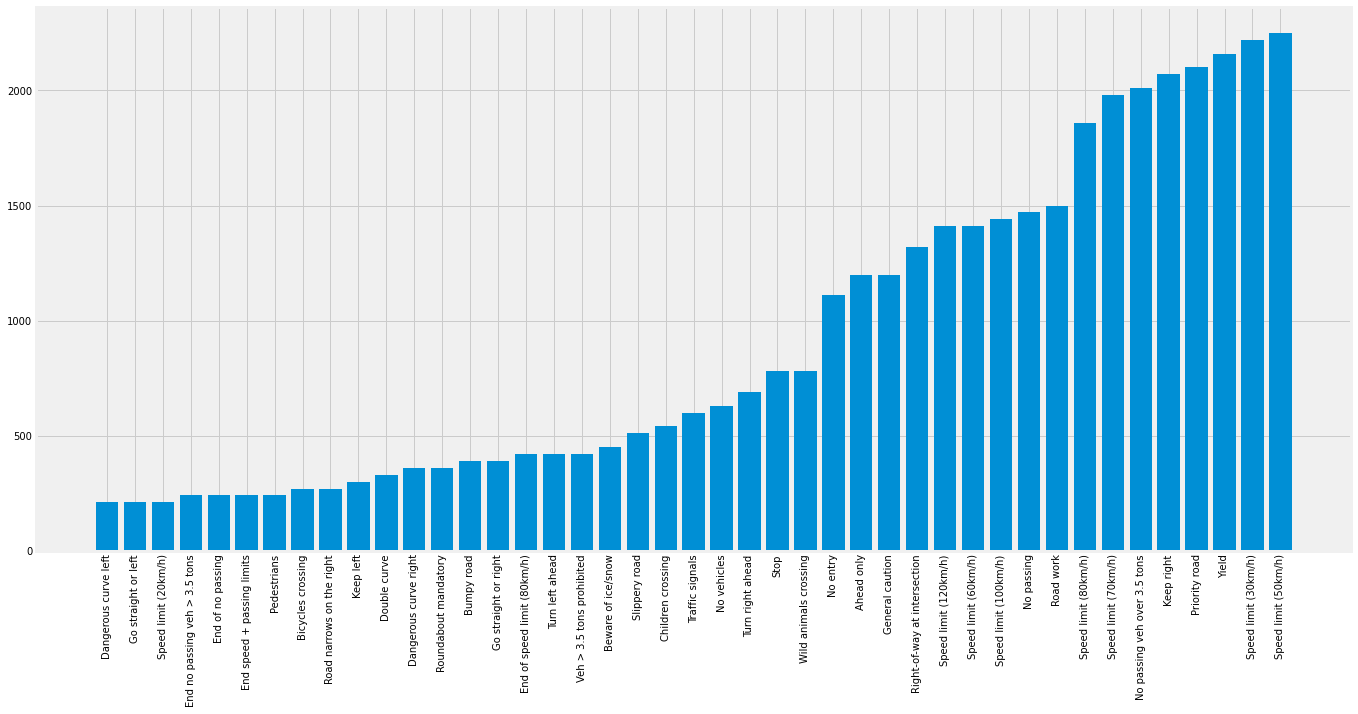

In [16]:
folders = os.listdir('/content/train')

train_num = []
class_num = []

for folder in folders:
  train_files = os.listdir(str(train_path) + '/' + folder)
  train_num.append(len(train_files))
  class_num.append(classes[int(folder)])
  
zipped_lists = zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in tuples]

plt.figure(figsize = (21, 10))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

- 어떤 표지판의 데이터가 가장 많은지 시각화

In [20]:
def load_data(data_dir):
  images = list()
  labels = list()
  for category in range(NUM_CATEGORIES):
    categories = os.path.join(data_dir, str(category))
    for img in os.listdir(categories):
      img = load_img(os.path.join(categories, img), target_size=(IMG_WIDTH, IMG_HEIGHT))
      image = img_to_array(img)
      images.append(image)
      labels.append(category)
  
  return images, labels

- 경로값을 인자값으로 하여 데이터를 로드하는 함수 생성

In [21]:
images, labels = load_data(train_path)

- 변수 images, labels에 데이터 로드

In [22]:
labels = to_categorical(labels)

- labels에 대하여 원핫인코딩 실행

- 원핫인코딩이란?
  - 원-핫 인코딩은 데이터 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 데이터의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식

In [23]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.4)

- 트레인 데이터 셋, 테스트 데이터 셋 분류

In [24]:
model = Sequential()

- 순차적으로 레이어(층)를 쌓을 수 있는 객체(인공지능 신경망의 뼈대와 같은 역할)

In [27]:
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNAL)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))              

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

- Conv2D: 필터를 사용하여 이미지의 특징을 뽑아주는 합성곱(convolution) 레이어
  - filter: 하나의 특징을 가지고도 여러 개로 분류하여 학습시킴으로써 정확성을 높여준다
  - kernel_size: 하나의 커널을 3x3으로 한다
  - activation: relu라는 활성화 함수를 사용하라는 의미
- MaxPool2D: 컨볼루션 레이어의 출력 이미지에서 핵심 값을 추출하여 지역적인 사소한 변화륾 무시하기 위해 사용
  - 가로 세로 최대 2픽셀 4칸을 하나의 픽셀로 보고 그 중 하나의 최댓값을 한 픽셀로 취급한다
- Dropout: 오버핏팅을 막기 위해서 일정 비율을 걸러낸다


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

- 간단한 신경망 모델이 만들어졌음을 알 수 있음

In [29]:
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

 - Flatten(): 만들어진 여러 레이어들을 1차원으로 표현해주는 값
  - 최종적으러 만들어진 레이러들을 하나로 합쳐줘야만 하나의 이미지가 들어가서 하나의 결과값이 나온다
 - Dense(): 뉴런의 입력과 출력을 연결시켜주는 역할
  - 첫 번째 인자 -> 뉴런의 출력 갯수
 why??

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

- 최종 신경망 모델

In [31]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

- 최종적으로 신경망 모델을 학습시키기 위해 컴파일
- loss: 원본과 얼마나 차이가 나는지에 대한 정보(손실값), crossentropy: 분류 문제에서 자주 사용 
- optimizer: loss값으로 부터 얻은 정보로 모델을 업데이트
- metrics: 훈련 모니터링에 사용


In [32]:
EPOCHS = 30
history = model.fit(x_train, 
                    y_train,
                    validation_data = (x_test, y_test), 
                    epochs=EPOCHS, 
                    steps_per_epoch=60
                   )

Epoch 1/30
60/60 [==============================] - 36s 587ms/step - loss: 4.9906 - accuracy: 0.0566 - val_loss: 3.3005 - val_accuracy: 0.1690
Epoch 2/30
60/60 [==============================] - 35s 591ms/step - loss: 2.8353 - accuracy: 0.2808 - val_loss: 2.1567 - val_accuracy: 0.4501
Epoch 3/30
60/60 [==============================] - 43s 727ms/step - loss: 1.7829 - accuracy: 0.5026 - val_loss: 1.1164 - val_accuracy: 0.7015
Epoch 4/30
60/60 [==============================] - 34s 569ms/step - loss: 1.0041 - accuracy: 0.7119 - val_loss: 0.5920 - val_accuracy: 0.8592
Epoch 5/30
60/60 [==============================] - 45s 751ms/step - loss: 0.6435 - accuracy: 0.8132 - val_loss: 0.3703 - val_accuracy: 0.9150
Epoch 6/30
60/60 [==============================] - 36s 597ms/step - loss: 0.4740 - accuracy: 0.8612 - val_loss: 0.3054 - val_accuracy: 0.9333
Epoch 7/30
60/60 [==============================] - 37s 623ms/step - loss: 0.3806 - accuracy: 0.8914 - val_loss: 0.2143 - val_accuracy: 0.9504

- 모델 학습시키기

In [37]:
loss, accuracy = model.evaluate(x_test, y_test)
  
print('test set accuracy: ', accuracy * 100)

491/491 [==============================] - 7s 15ms/step - loss: 0.0719 - accuracy: 0.9840
test set accuracy:  98.39964509010315


- 학습까지 시킨 최종적인 모델에 대한 정확도의 손실 정도에 대한 결과 값

In [39]:
Y_test = pd.read_csv('/content/Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

a = pathlib.Path('/content/')

output = list()

for img in test_images:
  image = load_img(os.path.join(a, img), target_size=(IMG_WIDTH, IMG_HEIGHT))
  output.append(np.array(image))

X_test = np.array(output)
y_prob = model.predict(X_test)
pred = y_prob.argmax(axis=-1)

print('Test Data Accuracy: ', accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 7s 18ms/step
Test Data Accuracy:  93.74505146476643


- 테스트 데이터를 활용하여 테스트 데이터의 정확도 확인

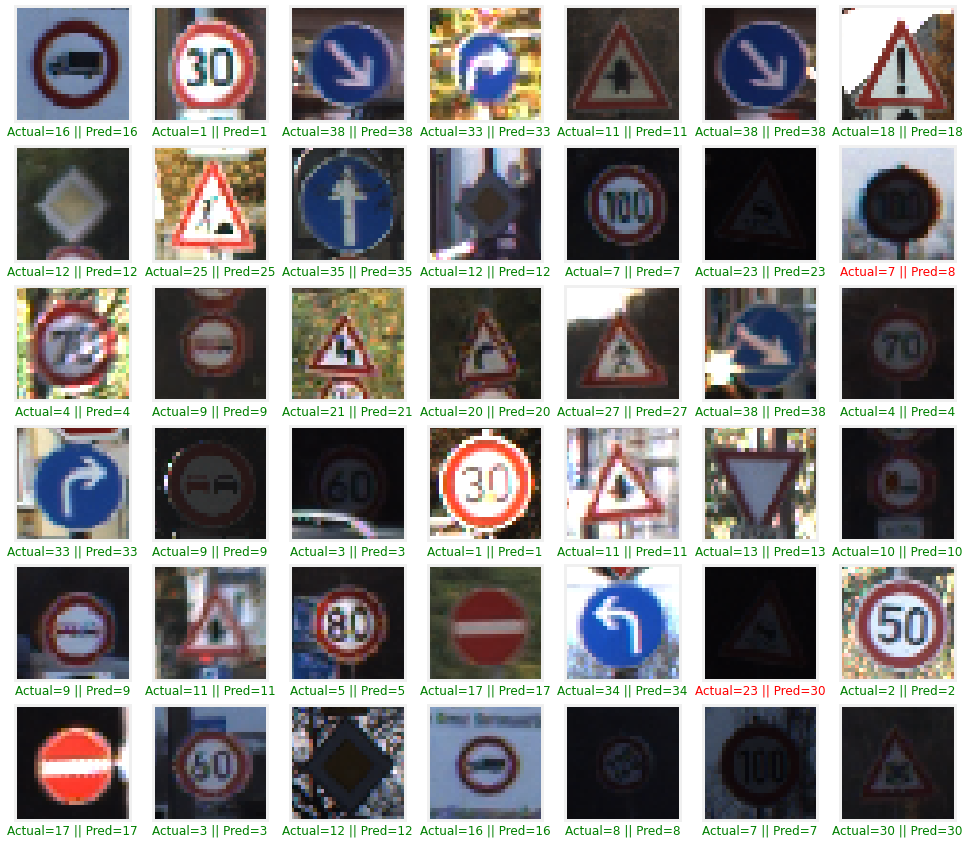

In [40]:
plt.figure(figsize=(15,15))

start_index = 0
for i in range(42):
  plt.subplot(6, 7, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  prediction = pred[start_index + i]
  actual = test_labels[start_index + i]
  col = 'g'
  if prediction != actual:
    col = 'r'
  plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color=col)
  plt.imshow(X_test[start_index + i])

plt.show()

- 테스트 데이터들을 활용하여 신경망을 돌렸을 때, 각 데이터들의 첫번째 사진 파일들을 불러와서 테스트한 결과들 시각화